In [8]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [10]:
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap

# RGB
colors_rgb = {
    0: (0x00, 0x00, 0x00),
    1: (0x00, 0x74, 0xD9),
    2: (0xFF, 0x41, 0x36),
    3: (0x2E, 0xCC, 0x40),
    4: (0xFF, 0xDC, 0x00),
    5: (0xA0, 0xA0, 0xA0),
    6: (0xF0, 0x12, 0xBE),
    7: (0xFF, 0x85, 0x1B),
    8: (0x7F, 0xDB, 0xFF),
    9: (0x87, 0x0C, 0x25),
}

_float_colors = [tuple(c / 255 for c in col) for col in colors_rgb.values()]
arc_cmap = ListedColormap(_float_colors)

class ArcColors:
    BLACK = 0
    BLUE = 1
    RED = 2
    GREEN = 3
    YELLOW = 4
    GREY = 5
    FUCHSIA = 6
    ORANGE = 7
    TEAL = 8
    BROWN = 9

def plot_grid(grid1: np.ndarray, grid2: np.ndarray = None):
    
    if grid2 is None:
        fig, ax = plt.subplots()
        ax.pcolormesh(
            grid1,
            cmap=arc_cmap,
            rasterized=True,
            vmin=0,
            vmax=9,
        )
        ax.set_xticks(np.arange(0, grid1.shape[1], 1))
        ax.set_yticks(np.arange(0, grid1.shape[0], 1))
        ax.grid()
        ax.set_aspect(1)
        ax.invert_yaxis()
        plt.show()
        return
    
    fig, axs = plt.subplots(1, 2)

    axs[0].pcolormesh(
        grid1,
        cmap=arc_cmap,
        rasterized=True,
        vmin=0,
        vmax=9,
    )
    axs[0].set_xticks(np.arange(0, grid1.shape[1], 1))
    axs[0].set_yticks(np.arange(0, grid1.shape[0], 1))
    axs[0].grid()
    axs[0].set_aspect(1)
    axs[0].invert_yaxis()

    axs[1].pcolormesh(
        grid2,
        cmap=arc_cmap,
        rasterized=True,
        vmin=0,
        vmax=9,
    )
    axs[1].set_xticks(np.arange(0, grid2.shape[1], 1))
    axs[1].set_yticks(np.arange(0, grid2.shape[0], 1))
    axs[1].grid()
    axs[1].set_aspect(1)
    axs[1].invert_yaxis()
    plt.show()

### Load the data

In [11]:
import os
# Load the data from the data/train directory containing the json files
# files are named {random_number}.json so you need to list all the files in the directory and then load the data from each file
training_data_dir = "../data/training"
evaluating_data_dir = "../data/evaluation"

# List of JSON file paths
# training_file_paths = [os.path.join(training_data_dir, f) for f in os.listdir(training_data_dir)]
# evaluating_file_paths = [os.path.join(evaluating_data_dir, f) for f in os.listdir(evaluating_data_dir)]
training_file_paths = [os.path.join(training_data_dir, "3c9b0459.json")]
evaluating_file_paths = [os.path.join(training_data_dir, "3c9b0459.json")]

In [12]:
import json
# Function to load data from multiple files

def load_data(file_paths):
    train_data = []
    test_data = []
    for file_path in file_paths:
        rules_input = []
        test_input = []
        with open(file_path, 'r') as f:
            data = json.load(f)
            for item in data['train']:
                rules_input.append([
                    np.array(item['input'], dtype=np.int64),
                    np.array(item['output'], dtype=np.int64)
                ])
            for item in data['test']:
                test_input.append([
                    np.array(item['input'], dtype=np.int64),
                    np.array(item['output'], dtype=np.int64)
                ])
        train_data.append(rules_input)
        test_data.append(test_input)
    return train_data, test_data

# Load data from multiple files
training_train_data, training_test_data = load_data(training_file_paths)
evaluating_train_data, evaluating_test_data = load_data(evaluating_file_paths)

### Data Preprocessing
We setup the data to be fed into the model into a 32x32 grid

In [13]:
def normalize_data(data):
    return data / 9.0

def denormalize_data(data):
    return data * 9.0

def expand_squared_matrix(matrix, size):
    max_size = size
    current_size = matrix.shape[0]
    if current_size == max_size:
        return normalize_data(matrix)
    
    ratio = max_size / current_size
    floor_ratio = int(np.floor(ratio))
    
    if floor_ratio * current_size == max_size:
        return normalize_data(matrix.repeat(floor_ratio, axis=0).repeat(floor_ratio, axis=1))
    
    resized_matrix = matrix.repeat(floor_ratio, axis=0).repeat(floor_ratio, axis=1)
    pad_size = max_size - resized_matrix.shape[0]
    
    padded_matrix = np.full((max_size, max_size), 0)
    padded_matrix[pad_size//2:pad_size//2+resized_matrix.shape[0], pad_size//2:pad_size//2+resized_matrix.shape[1]] = resized_matrix
    
    return normalize_data(padded_matrix)

def expand_rectangular_matrix(matrix, size):
    max_size = 32
    current_size = matrix.shape[0]
    current_width = matrix.shape[1]
    if current_size == max_size and current_width == max_size:
        return normalize_data(matrix)
    ratio = max_size // current_size
    ratio_width = max_size // current_width
    divisible = ratio * current_size == max_size and ratio_width * current_width == max_size
    if divisible is True:
       return normalize_data(matrix.repeat(ratio, axis=0).repeat(ratio_width, axis=1))

    ## if the size is not divisible by 32
    ## we need to add padding and center the reiszed image
    floor_ratio = np.floor(ratio)
    floor_ratio_width = np.floor(ratio_width)
    resized_matrix = matrix.repeat(floor_ratio, axis=0).repeat(floor_ratio_width, axis=1)
    pad_size = max_size - resized_matrix.shape[0]
    pad_size_width = max_size - resized_matrix.shape[1]
    padded_matrix = np.full(size, 0)
    padded_matrix[pad_size//2:pad_size//2+resized_matrix.shape[0], pad_size_width//2:pad_size_width//2+resized_matrix.shape[1]] = resized_matrix
    return normalize_data(padded_matrix)

def expand_matrix(matrix, size):
    if matrix.shape[0] == matrix.shape[1]:
        return expand_squared_matrix(matrix, size[0])
    return expand_rectangular_matrix(matrix, size)


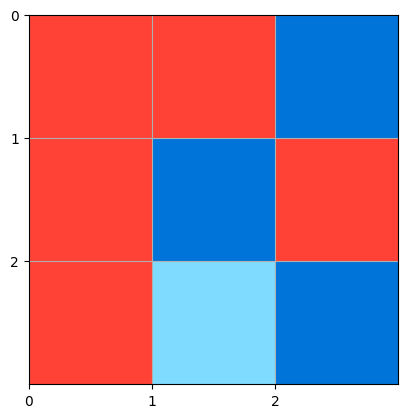

In [14]:
# test expand_matrix
plot_grid(denormalize_data(expand_matrix(training_train_data[0][0][0], (3, 3))))

In [15]:
MAX_SHAPE = (3, 3)

### Data preparation for the transformer model

In [16]:
def extract_data_for_transformer(train, test, max_shape=MAX_SHAPE):
    pairs = []
    for i, element in enumerate(train):
        expanded_0 = expand_matrix(element[0], max_shape)
        expanded_1 = expand_matrix(element[1], max_shape)
        pairs.append(expanded_0)
        pairs.append(expanded_1)


    final_test = expand_matrix(test[0][0], max_shape)
    attended_output = expand_matrix(test[0][1], max_shape)
    return pairs, final_test, attended_output

def extract_batch (data, test):
    batches = []
    for i in range(0, len(data)):
        extracted = extract_data_for_transformer(data[i], test[i])
        batches.append(extracted)
        ### augment the data
        for j in range(3):
            rotated = [[np.rot90(x, j+1) for x in extracted[0]], np.rot90(extracted[1], j+1), np.rot90(extracted[2], j+1)]
            batches.append(rotated)
            batches.append([[np.flip(x, 0) for x in rotated[0]], np.flip(rotated[1], 0), np.flip(rotated[2], 0)])
        batches.append([[np.flip(x, 1) for x in extracted[0]], np.flip(extracted[1], 1), np.flip(extracted[2], 1)])
    return batches

train_data = extract_batch(training_train_data[:1], training_test_data[:1])
eval_data = extract_batch(evaluating_train_data[:1], evaluating_test_data[:1])

### Layer to process pairs of data

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input

class ProcessPairsLayer(layers.Layer):
    def __init__(self, input_shape, pos_encoding, **kwargs):
        super(ProcessPairsLayer, self).__init__(**kwargs)
        self.input_shape_ = input_shape
        self.pos_encoding = pos_encoding
        self.head_size = 32 # 64 -> 32 to reduce the number of parameters
        self.num_heads = 2 # 4 -> 2 to reduce the number of parameters 
        self.ff_dim = 64 # 128 -> 64 to reduce the number of parameters
        self.dropout = 0.1

    def build(self, input_shape):
        self.mha_layers = [layers.MultiHeadAttention(key_dim=self.head_size, num_heads=self.num_heads, dropout=self.dropout) for _ in range(2)]
        self.ffn_layers = [self.build_ffn() for _ in range(2)]
        super(ProcessPairsLayer, self).build(input_shape)

    def build_ffn(self):
        return tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(self.ff_dim, activation=tf.nn.gelu),
            layers.Dropout(self.dropout),
            layers.Dense(self.input_shape_[2])
        ])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_pairs = tf.shape(inputs)[1]

        reshaped_inputs = tf.reshape(inputs, (batch_size * num_pairs, self.input_shape_[0] * self.input_shape_[1], self.input_shape_[2]))
        x = reshaped_inputs + self.pos_encoding

        for mha_layer, ffn_layer in zip(self.mha_layers, self.ffn_layers):
            x = mha_layer(x, x)
            x = layers.Dropout(self.dropout)(x)
            x = layers.Add()([x, reshaped_inputs])
            x = ffn_layer(x)
            x = layers.Add()([x, reshaped_inputs])

        x = tf.reshape(x, (batch_size, num_pairs * self.input_shape_[0] * self.input_shape_[1], self.input_shape_[2]))
        return x

### Positional Encoding

In [18]:
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


### Transformer model

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def custom_accuracy(y_true, y_pred):
    threshold = 0.1
    diff = tf.abs(y_true - y_pred)
    correct_predictions = tf.less(diff, threshold)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


def create_transformer_model(input_shape):
    pos_encoding = positional_encoding(input_shape[0] * input_shape[1], input_shape[2])

    input_layer = Input(shape=(None, input_shape[0], input_shape[1], input_shape[2]))
    processed_pairs = ProcessPairsLayer(input_shape, pos_encoding)(input_layer)

    x = layers.LayerNormalization(epsilon=1e-6)(processed_pairs)
    for _ in range(2):
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.1)(x, x)
        x = layers.Dropout(0.1)(x)
        x = layers.Add()([x, processed_pairs])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dense(128, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(input_shape[2])(x)
        x = layers.Add()([x, processed_pairs])

    final_input = Input(shape=input_shape)
    flattened_final_input = layers.Reshape((input_shape[0] * input_shape[1], input_shape[2]))(final_input)
    x_final = flattened_final_input + pos_encoding

    for _ in range(2):
        x_final = layers.LayerNormalization(epsilon=1e-6)(x_final)
        x_final = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.1)(x_final, x_final)
        x_final = layers.Dropout(0.1)(x_final)
        x_final = layers.Add()([x_final, flattened_final_input])
        x_final = layers.LayerNormalization(epsilon=1e-6)(x_final)
        x_final = layers.Dense(128, activation=tf.nn.gelu)(x_final)
        x_final = layers.Dropout(0.1)(x_final)
        x_final = layers.Dense(input_shape[2])(x_final)
        x_final = layers.Add()([x_final, flattened_final_input])

    flattened_x_final = layers.Reshape((-1,))(x_final)

    def repeat_vector(args):
        x, rep = args
        return tf.repeat(x, repeats=rep, axis=1)

    expanded_final_input = layers.Lambda(repeat_vector)([flattened_x_final, tf.shape(x)[1]])

    def reshape_combined(args):
        x, combined_shape = args
        return tf.reshape(x, (-1, combined_shape, input_shape[0] * input_shape[1] * input_shape[2]))

    expanded_final_input = layers.Lambda(reshape_combined)([expanded_final_input, tf.shape(x)[1]])

    def flatten_combined_pairs(x):
        shape = tf.shape(x)
        return tf.reshape(x, (-1, shape[1], shape[2]))

    combined_pairs_flat = layers.Lambda(flatten_combined_pairs)(x)
    expanded_final_input_flat = layers.Lambda(flatten_combined_pairs)(expanded_final_input)

    x_combined = layers.Concatenate(axis=-1)([combined_pairs_flat, expanded_final_input_flat])

    x = layers.LayerNormalization(epsilon=1e-6)(x_combined)
    for _ in range(2):
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.1)(x, x)
        x = layers.Dropout(0.1)(x)
        x = layers.Add()([x, x_combined])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dense(128, activation=tf.nn.gelu)(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(input_shape[2])(x)
        x = layers.Add()([x, x_combined])

    x = layers.Dense(input_shape[0] * input_shape[1] * input_shape[2])(x)
    def dynamic_reshape(tensor, shape):
        return tf.reshape(tensor, shape)

    output_shape = (-1, input_shape[0], input_shape[1], input_shape[2])
    x = layers.Lambda(dynamic_reshape, arguments={'shape': output_shape})(x)

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x) # 32 -> 16 to reduce the number of parameters
    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x) # 32 -> 16 to reduce the number of parameters
    x = layers.Conv2D(input_shape[2], 3, padding="same", activation="sigmoid")(x)

    model = models.Model(inputs=[input_layer, final_input], outputs=x)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[custom_accuracy])
    return model

input_shape = (3, 3, 1)
model = create_transformer_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3, 3, 1)]      0         []                            
                                                                                                  
 process_pairs_layer (Proce  (None, None, 1)              965       ['input_1[0][0]']             
 ssPairsLayer)                                                                                    
                                                                                                  
 input_2 (InputLayer)        [(None, 3, 3, 1)]            0         []                            
                                                                                                  
 layer_normalization (Layer  (None, None, 1)              2         ['process_pairs_layer[0][0

In [20]:
@tf.function
def prepare_prediction_input(pairs, final_input):
    """
    Prepare the input for prediction by stacking the input-output pairs
    and the final input matrix.

    :param pairs: List of input-output pairs (e.g., 8 matrices for 4 pairs).
    :param final_input: The final input matrix to complete.
    :return: Tuple of (stacked input pairs, final input matrix).
    """
    pairs_tensor = tf.stack(pairs, axis=0)
    pairs_tensor = tf.expand_dims(pairs_tensor, axis=0)  # Add batch dimension
    final_input_tensor = tf.expand_dims(final_input, axis=0)  # Add batch dimension
    return pairs_tensor, final_input_tensor


In [21]:
#overfit_test = prepare_prediction_input(train_data[0][0], train_data[0][1])
## cut the train_data[0][0] to 1 pairs
cutted_pairs = train_data[0][0][:2]
overfit_test = prepare_prediction_input(cutted_pairs, train_data[0][1])
overfit_output = np.expand_dims(train_data[0][2], 0)

2024-06-16 11:29:26.721369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
model.predict(overfit_test)

2024-06-16 11:29:27.120807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


array([[[[0.523352  ],
         [0.48432517],
         [0.47899544]],

        [[0.49543628],
         [0.4580811 ],
         [0.4624604 ]],

        [[0.49470523],
         [0.46637708],
         [0.4371475 ]]],


       [[[0.523352  ],
         [0.48432517],
         [0.47899544]],

        [[0.49543628],
         [0.4580811 ],
         [0.4624604 ]],

        [[0.49470523],
         [0.46637708],
         [0.4371475 ]]],


       [[[0.51909256],
         [0.48755103],
         [0.48295993]],

        [[0.49643174],
         [0.46590668],
         [0.46939623]],

        [[0.49548057],
         [0.47305068],
         [0.44899997]]],


       [[[0.5250196 ],
         [0.48682538],
         [0.4791519 ]],

        [[0.49637684],
         [0.45688072],
         [0.4608141 ]],

        [[0.49236166],
         [0.46872288],
         [0.4375427 ]]],


       [[[0.51909256],
         [0.48755103],
         [0.48295993]],

        [[0.49643174],
         [0.46590668],
         [0.46939623]],

In [ ]:
model.fit(overfit_test, overfit_output, epochs=1, verbose=1, batch_size=1)

2024-06-16 11:29:30.962691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
def display_output(output_1, output_2=None):
    output_1 = output_1.reshape(MAX_SHAPE[0], MAX_SHAPE[1])
    output_1 = denormalize_data(output_1)
    
    if output_2 is None:
        plot_grid(output_1)
        return
    output_2 = denormalize_data(output_2)
    output_2 = output_2.reshape(MAX_SHAPE[0], MAX_SHAPE[1])
    plot_grid(output_1, output_2)

In [ ]:
result = model.predict(overfit_test)
display_output(result[0, :, :, 0], overfit_output[0])